<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Установка-библиотек" data-toc-modified-id="Установка-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Установка библиотек</a></span></li><li><span><a href="#Бибилотеки" data-toc-modified-id="Бибилотеки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Бибилотеки</a></span></li><li><span><a href="#Параметры" data-toc-modified-id="Параметры-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Параметры</a></span></li><li><span><a href="#Папка-под-город" data-toc-modified-id="Папка-под-город-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Папка под город</a></span></li><li><span><a href="#Скрипт" data-toc-modified-id="Скрипт-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Скрипт</a></span></li><li><span><a href="#Выгрузка-по-городу,-обзор-категорий" data-toc-modified-id="Выгрузка-по-городу,-обзор-категорий-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выгрузка по городу, обзор категорий</a></span></li><li><span><a href="#Point-to-point-load-from-OSM" data-toc-modified-id="Point-to-point-load-from-OSM-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Point-to-point load from OSM</a></span></li><li><span><a href="#KMZ-convetrer" data-toc-modified-id="KMZ-convetrer-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>KMZ-convetrer</a></span></li></ul></div>

# Установка библиотек

In [ ]:
# !pip install osmnx
# !pip install geopandas
# !pip install folium
# !pip install pyproj
# !pip install simplekml
#!pip install selenium

# Бибилотеки 

In [1]:
import geopandas as gpd
import osmnx as ox
from pyproj import CRS
import folium
from shapely import wkt
from shapely.geometry import box,mapping,polygon
import redshift_connector
import pandas as pd
from folium import plugins
import numpy as np
import os
import simplekml
from selenium import webdriver
from PIL import Image

# Параметры

In [21]:
city_name = 'Berlin'
tile="OpenStreetMap"

# Папка под город

In [22]:
# if not os.path.exists(city_name):
#        os.makedirs(city_name)

# Скрипт 

In [23]:
 # Данные по городу
gdf = ox.geocode_to_gdf(city_name,which_result=1) 
gdf = gdf.to_crs('epsg:4326')
gdf

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52...",52.675509,52.338245,13.761161,13.088345,381025747,relation,62422,52.517037,13.38886,boundary,administrative,8,0.787539,city,Berlin,"Berlin, Germany"


In [24]:
# Карта
m = folium.Map([gdf.to_crs(4326).centroid.x,
                gdf.to_crs(4326).centroid.y], 
                tiles=tile,zoom_start=3)
folium.FitBounds([[gdf.bounds.miny[0], gdf.bounds.minx[0]],[gdf.bounds.maxy[0], gdf.bounds.maxx[0]]]).add_to(m)

C:\Users\PC\AppData\Local\Temp\ipykernel_25924\2136690441.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map([gdf.to_crs(4326).centroid.x,
C:\Users\PC\AppData\Local\Temp\ipykernel_25924\2136690441.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.to_crs(4326).centroid.y],


In [25]:
# Заключение города в прямоугольник
bounds_box_polygon = box(*gdf.to_crs('epsg:4326').total_bounds[::-1],ccw=False)
folium.PolyLine(bounds_box_polygon.exterior.coords,
               color='green',
               opacity = 0.4,
               weight =2,
               fill_opacity=0.05)\
               .add_to(m)

# Выгрузка по городу, обзор категорий

In [26]:
top = pd.read_csv(os.path.join('data', f'{city_name}.csv'))
top.rename(columns={'point':'wkt_point','count':'saved'},inplace=True)

In [27]:
top.head(1000)

,Unnamed: 0,wkt_point,saved
0,0,POINT (13.388880895242808 52.517047989179446),988
1,1,POINT (13.388880895242806 52.517047989179446),972
2,2,POINT (13.40102712363769 52.51908641857943),946
3,3,POINT (13.3777026338704 52.51627500804057),568
4,4,POINT (13.435862313478168 52.50746747763144),510
...,...,...,...
95,95,POINT (13.381523440640592 52.487738605971096),73
96,96,POINT (13.409598122608656 52.54020745496532),73
97,97,POINT (13.439917813538898 52.504950016442535),72
98,98,POINT (13.43133206241825 52.48207075662495),72


In [28]:
def convert_to_gpd(df):
    df.reset_index(inplace=True)
    geometry = gpd.GeoSeries.from_wkt(df["wkt_point"])
    gdf = gpd.GeoDataFrame(df['saved'], crs="EPSG:4326", geometry=geometry)
    gdf.crs = 'epsg:4326'
    return gdf

In [29]:
geo_top = convert_to_gpd(top)

In [30]:
geo_top

,saved,geometry
0,988,POINT (13.38888 52.51705)
1,972,POINT (13.38888 52.51705)
2,946,POINT (13.40103 52.51909)
3,568,POINT (13.37770 52.51628)
4,510,POINT (13.43586 52.50747)
...,...,...
95,73,POINT (13.38152 52.48774)
96,73,POINT (13.40960 52.54021)
97,72,POINT (13.43992 52.50495)
98,72,POINT (13.43133 52.48207)


# Point-to-point load from OSM

In [31]:
toogle = folium.FeatureGroup(name="All")

geo_top['lon'] = geo_top.geometry.x
geo_top['lat'] = geo_top.geometry.y

geo_top.apply(lambda row:
             toogle.add_child(
             folium.CircleMarker(
             location=[row['lat'],row['lon']],
             fill=True,
             popup='Saved ' + str(row['saved']))),axis=1)

m.add_child(toogle)

In [32]:
m.save(os.path.join('data', f'{city_name}.html'))

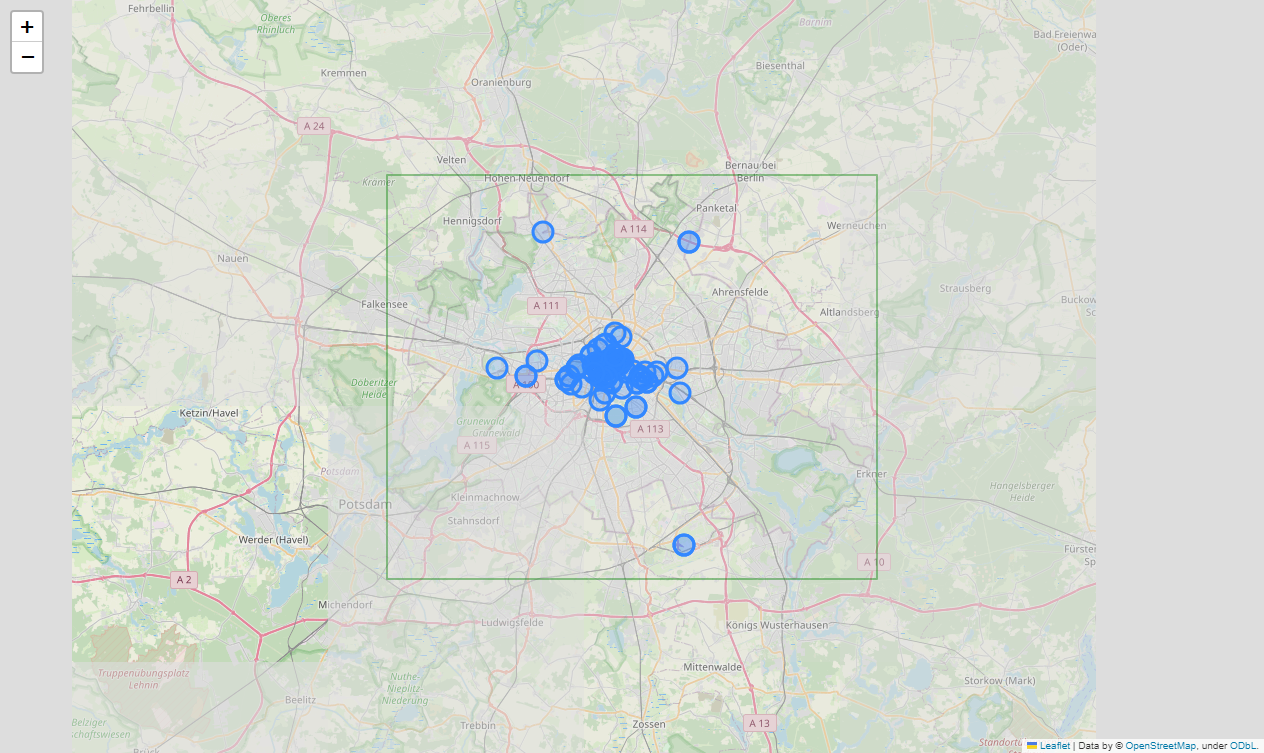

In [33]:
options = webdriver.ChromeOptions()
options.add_argument('--disable-gpu')
options.add_argument('no-sandbox')
driver = webdriver.Chrome(options=options)

# Открываем HTML файл с картой
driver.get('file:///' + os.path.abspath(os.path.join('data', f'{city_name}.html')))

# Задаем размеры окна
driver.set_window_size(1_280, 900)

# Делаем скриншот
driver.save_screenshot(os.path.join('data', city_name + '.png'))

# Закрываем драйвер
driver.quit()

# Опционально можем обработать изображение с помощью Pillow
image = Image.open(os.path.join('data', city_name + '.png'))
image

# KMZ-convetrer 

In [ ]:
kml = simplekml.Kml(name=f"{city_name} guide bookmarks")

In [ ]:
geo_top.apply(
lambda bookmark:
    kml.newpoint(
    description = f'''Saved times: {bookmark.saved}
Position in top for year - {bookmark.name}''',
    coords=[(bookmark.geometry.x,bookmark.geometry.y)]
            ),
                axis=1
    )

In [ ]:
kml.savekmz(os.path.join('data', f'{city_name}.kmz'),format=False)